In [1]:
import torch
import torch.nn
import torch.nn.functional as F
import numpy as np
import re

In [47]:
f = open("../datasets/1984chapter.txt", "r")

corpus = f.read()

corpus = re.sub('\,|\.', '', corpus.lower()).split(' ')

In [48]:
from sklearn.preprocessing import OneHotEncoder

unique_words = np.unique(corpus)
ohe = OneHotEncoder(sparse_output=False).fit_transform(unique_words.reshape(-1, 1))
lookup = dict([(k, enc) for enc, k in zip(ohe, unique_words.tolist())])
d = unique_words.shape[0]

In [53]:
from sklearn.neural_network import MLPClassifier

L = 5 # window size (middle is used as conditional)
k = 2 # factor to determine amount of negative examples
h = 200 # hidden layer size

embeddings = np.zeros((d, h))
clf = MLPClassifier(hidden_layer_sizes=[h], max_iter=500)

for i in range(len(corpus) - L + 1):
    X = []
    y = []
    pos_examples = corpus[i: i+L]
    for i, w in enumerate(pos_examples):
        if i == L//2: continue
        X.append(lookup[w]) 
        y.append(1)

    neg_examples = []
    while len(neg_examples) < k*(L-1):
        w = np.random.choice(corpus)
        if w in pos_examples: continue
        neg_examples.append(w) 

    for w in neg_examples:
        X.append(lookup[w])
        y.append(0)

    X = np.array(X)
    y = np.array(y)
    
    # print(X.shape, y.shape)
    for _ in range(100):
        clf = clf.partial_fit(X, y, [0, 1])

embeddings = clf.coefs_[0]

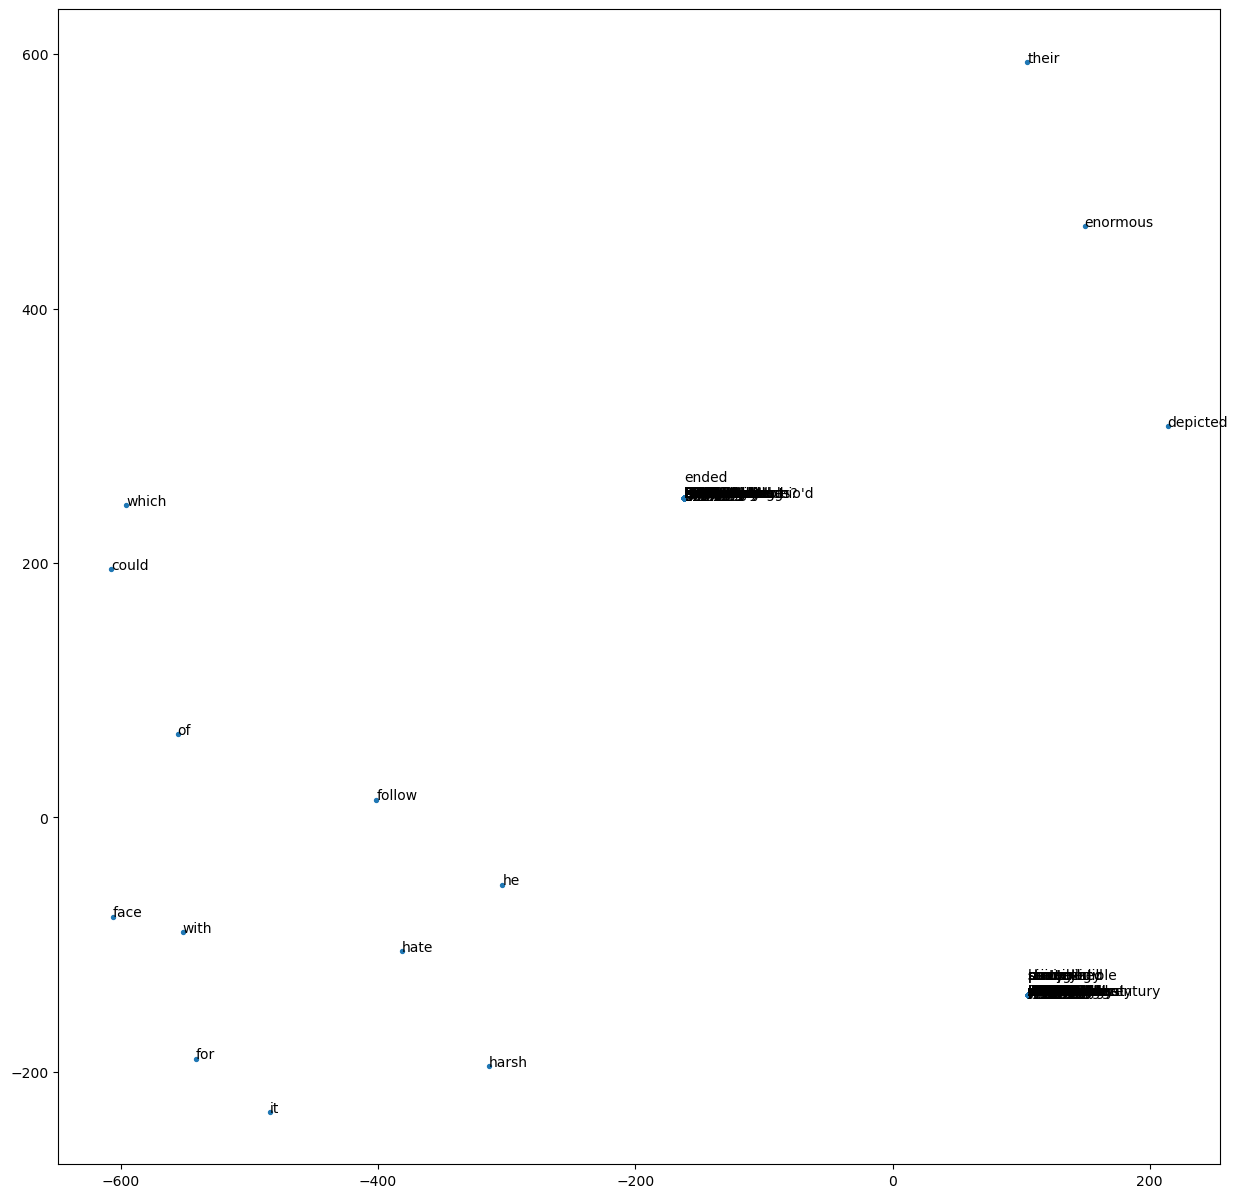

In [58]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

proj_emb = TSNE(perplexity=60).fit_transform(embeddings)
plt.figure(figsize=(15, 15))
plt.scatter(proj_emb[:, 0], proj_emb[:, 1], s=8)
for k, x in zip(lookup.keys(), proj_emb):
    plt.annotate(k, (x[0]+0.02, x[1]))